In [145]:
#
# Libraries
#

# General
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly import figure_factory as ff
from plotly.subplots import make_subplots
import plotly.io as pio

# Sklearn
from sklearn.model_selection import *
from sklearn.feature_extraction import *
from sklearn.metrics import *
from sklearn.metrics import pairwise
from sklearn.preprocessing import *
from sklearn.utils import *
from sklearn.pipeline import *
from sklearn.compose import *
from sklearn.covariance import *
from sklearn.multioutput import *
from sklearn.ensemble import *
from sklearn.tree import *

# Stats
import scipy
from scipy.stats import *
from scipy.sparse import csr_matrix

# Optuna
import optuna

In [146]:
#
# Data
#

# base path
base_path = './agric-data/'
fraction = 0.25

# farmer advisor ds
fa_ds = pd.read_csv(base_path+'farmer_advisor_dataset.csv')
fa_ds = fa_ds.sample(frac=fraction, random_state=42)  # 10% sample
fa_ds.sort_values('Crop_Type',inplace=True)

# market researcher ds
mr_ds = pd.read_csv(base_path+'market_researcher_dataset.csv')
mr_ds = mr_ds.sample(frac=fraction, random_state=42)  # 10% sample
mr_ds.sort_values('Product',inplace=True)

In [147]:
seed = 100

# merge the datasets
df_mrg = pd.merge(fa_ds, mr_ds, left_on='Crop_Type', right_on='Product', how='inner').drop(['Farm_ID','Market_ID','Product'], axis=1)

# re-arrange columns
df_mrg = df_mrg[['Crop_Type','Soil_pH', 'Soil_Moisture', 'Temperature_C', 'Rainfall_mm',
       'Fertilizer_Usage_kg', 'Pesticide_Usage_kg', 'Crop_Yield_ton',
       'Market_Price_per_ton', 'Demand_Index','Supply_Index', 'Competitor_Price_per_ton', 'Economic_Indicator',
       'Weather_Impact_Score', 'Seasonal_Factor', 'Sustainability_Score','Consumer_Trend_Index']]

# drop NULLs (if any)
df_mrg.dropna(inplace=True)

# convert 'object' to category
for col in df_mrg.select_dtypes(include=['object']).columns:
    df_mrg[col] = df_mrg[col].astype('category')

In [148]:
# sampling
df = df_mrg

# View
df.head()

,Crop_Type,Soil_pH,Soil_Moisture,Temperature_C,Rainfall_mm,Fertilizer_Usage_kg,Pesticide_Usage_kg,Crop_Yield_ton,Market_Price_per_ton,Demand_Index,Supply_Index,Competitor_Price_per_ton,Economic_Indicator,Weather_Impact_Score,Seasonal_Factor,Sustainability_Score,Consumer_Trend_Index
0,Corn,6.507736,27.082668,24.765574,257.789657,118.046973,6.999838,8.44403,338.877176,158.083628,196.267733,113.517258,0.537737,7.537381,High,5.866555,94.791328
1,Corn,6.507736,27.082668,24.765574,257.789657,118.046973,6.999838,8.44403,180.532788,179.625610,193.077957,448.152123,0.967915,34.389256,Low,5.866555,97.730383
2,Corn,6.507736,27.082668,24.765574,257.789657,118.046973,6.999838,8.44403,230.604306,171.908654,116.704121,359.690122,1.151109,91.385072,Low,5.866555,74.397389
3,Corn,6.507736,27.082668,24.765574,257.789657,118.046973,6.999838,8.44403,211.854324,83.935442,179.047216,311.771342,1.439971,49.686893,Low,5.866555,94.684069
4,Corn,6.507736,27.082668,24.765574,257.789657,118.046973,6.999838,8.44403,250.565879,121.946782,157.257950,121.176057,0.912104,14.020212,High,5.866555,130.211510


<Axes: >

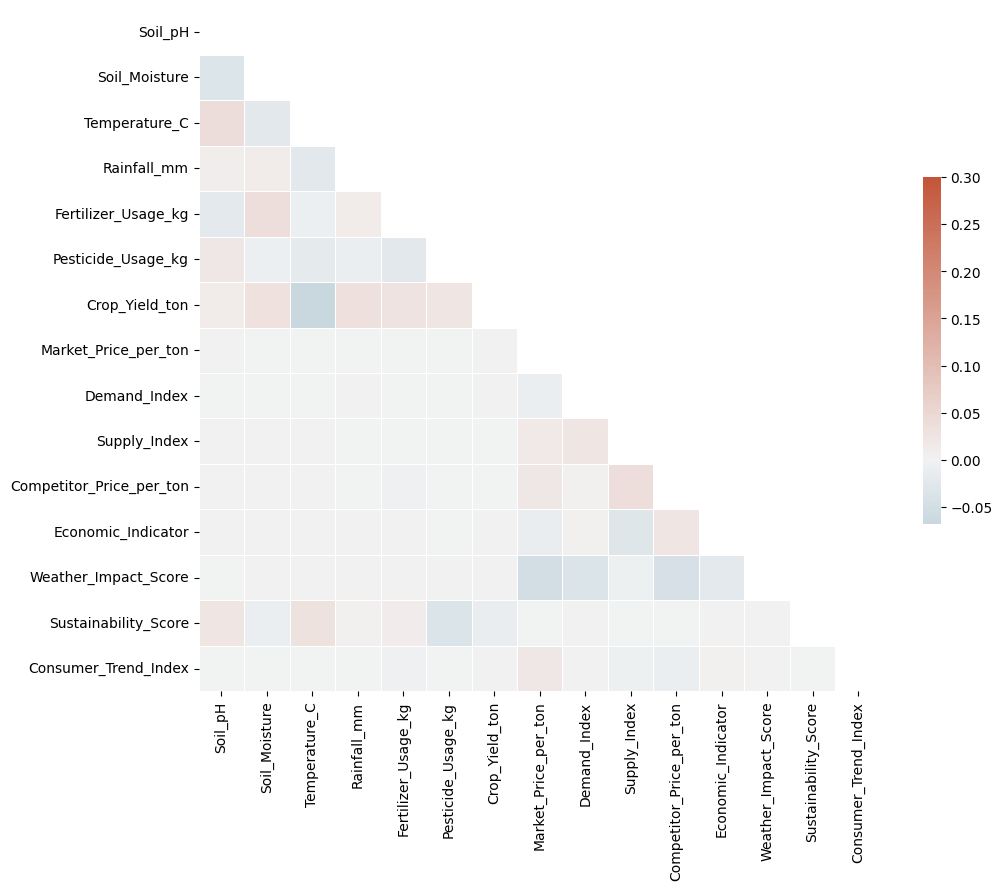

In [149]:
#
# Correlation Plot
#

# Compute the correlation matrix
corr = df.select_dtypes(include = ['float']).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [150]:
#
# Encoding
#
columns = ['Crop_Type','Seasonal_Factor']
le = LabelEncoder()

for c in columns:
    df[c] = le.fit_transform(df[c])

In [151]:
#
# Feature Engineering & Data Split
#

y = df[['Sustainability_Score','Consumer_Trend_Index']]  # Target
x = df.drop(columns=['Sustainability_Score','Consumer_Trend_Index'])  # Features

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)
print(f"Training Dataset: {x_train.shape[0]} | Testing Dataset: {x_test.shape[0]}")

Training Dataset: 1249401 | Testing Dataset: 312351


In [152]:
#
# Scaling
#

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)

In [153]:
#
# MOR Model Training
#

# Create multi-target regression model (RandomForest Regressor)
mo_model = MultiOutputRegressor(RandomForestRegressor(n_estimators=10, max_depth=3, min_samples_split=3, random_state=seed, n_jobs=-1,criterion='squared_error'),
                                n_jobs=3)

# Train
mo_model.fit(x_train_scaled,y_train)

,estimator,RandomForestR...dom_state=100)
,n_jobs,3
,n_estimators,10
,criterion,'squared_error'
,max_depth,3
,min_samples_split,3
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0


In [154]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
import numpy as np

In [155]:
#
# Prediction & Evaluation
#

# Predictions
y_pred = mo_model.predict(X_test_scaled)

print("MOR MAE for Target 1:", mean_absolute_error(y_test.iloc[:, 0], y_pred[:, 0]))
print("MOR MAE for Target 2:", mean_absolute_error(y_test.iloc[:, 1], y_pred[:, 1]))

print('')

print("MOR MAPE for Target 1:", mean_absolute_percentage_error(y_test.iloc[:, 0], y_pred[:, 0]) * 100)
print("MOR MAPE for Target 2:", mean_absolute_percentage_error(y_test.iloc[:, 1], y_pred[:, 1]) * 100)

print('')

print("MOR RMSE for Target 1:", np.sqrt(np.mean((y_test.iloc[:, 0] - y_pred[:, 0])**2)))
print("MOR RMSE for Target 2:", np.sqrt(np.mean((y_test.iloc[:, 1] - y_pred[:, 1])**2)))

print('')

print("MOR MSE for Target 1:", mean_squared_error(y_test.iloc[:, 0], y_pred[:, 0]))
print("MOR MSE for Target 2:", mean_squared_error(y_test.iloc[:, 1], y_pred[:, 1]))

MOR MAE for Target 1: 24.332376617179406
MOR MAE for Target 2: 24.672174842090065

MOR MAPE for Target 1: 898.8089358651425
MOR MAPE for Target 2: 28.63216413428904

MOR RMSE for Target 1: 28.289134618775833
MOR RMSE for Target 2: 28.5632196952466

MOR MSE for Target 1: 800.2751374792214
MOR MSE for Target 2: 815.8575193589235


In [156]:
#
# LR Model Training
#

from sklearn.linear_model import LinearRegression

# Create multi-target regression model (RandomForest Regressor)
lr_model = MultiOutputRegressor(LinearRegression(), n_jobs=3)

# Train
lr_model.fit(x_train_scaled,y_train)

,estimator,LinearRegression()
,n_jobs,3
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [157]:
#
# Prediction & Evaluation
#

# Predictions
y_pred = lr_model.predict(X_test_scaled)

print("LR MAE for Target 1:", mean_absolute_error(y_test.iloc[:, 0], y_pred[:, 0]))
print("LR MAE for Target 2:", mean_absolute_error(y_test.iloc[:, 1], y_pred[:, 1]))

print('')

print("LR MAPE for Target 1:", mean_absolute_percentage_error(y_test.iloc[:, 0], y_pred[:, 0]) * 100)
print("LR MAPE for Target 2:", mean_absolute_percentage_error(y_test.iloc[:, 1], y_pred[:, 1]) * 100)

print('')

print("LR RMSE for Target 1:", np.sqrt(np.mean((y_test.iloc[:, 0] - y_pred[:, 0])**2)))
print("LR RMSE for Target 2:", np.sqrt(np.mean((y_test.iloc[:, 1] - y_pred[:, 1])**2)))

print('')

print("LR MSE for Target 1:", mean_squared_error(y_test.iloc[:, 0], y_pred[:, 0]))
print("LR MSE for Target 2:", mean_squared_error(y_test.iloc[:, 1], y_pred[:, 1]))

LR MAE for Target 1: 24.62446112660437
LR MAE for Target 2: 25.002521190896356

LR MAPE for Target 1: 920.1940418526426
LR MAPE for Target 2: 29.05812038804062

LR RMSE for Target 1: 28.60087535828495
LR RMSE for Target 2: 28.92309291235705

LR MSE for Target 1: 818.0100712601511
LR MSE for Target 2: 836.5453036168386
